In [12]:
pip install pandas requests matplotlib mpi4py requests yfinance --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 102.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 12.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.9-cp310-cp310-linux_x86_64.whl size=971171 sha256=99d4c8c3581169a91a05c1de9a4cbeeaa0b638f06c04f2ba155f56103f077689
  Stored in directory: /home/jovyan/.cache/pip/wheels/fd/fd/5e/90b9ec95da4fd6c96237b580ce74f89d6bdea547ad151ab5f4
Successfully built peewee
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

In [1]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from mpi4py import MPI

In [6]:
TICKERS = ['TSLA', 'META', 'AMZN', 'NVDA', 'DELL', 'WDAY', 'SNPS', 'GOOG', 'MSFT', 'ADBE', 'MU']
API_KEY = os.getenv('API_KEY')  # Replace with your actual API key
START_DATE = "2023-01-01"
END_DATE = "2024-12-31"
NUM_SIMULATIONS = 10000
DAYS = 30

Value at Risk (95% confidence): 7.57%
Value at Risk (99% confidence): 13.21%


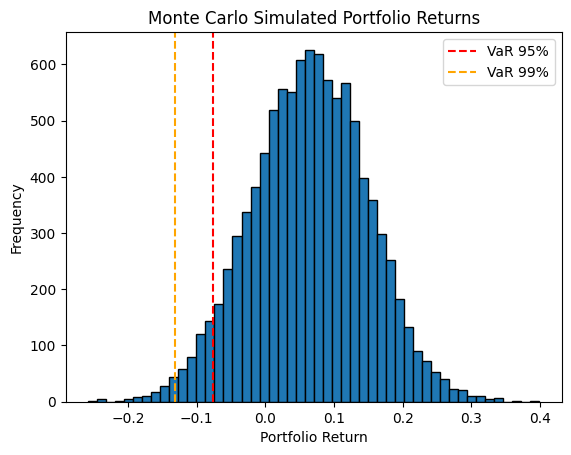

In [9]:
# Cell 3: Download Historical Prices
def get_prices(ticker):
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={START_DATE}&to={END_DATE}&apikey={API_KEY}"
    r = requests.get(url)
    data = r.json()
    prices = pd.DataFrame(data['historical'])[["date", "close"]].set_index("date")
    prices.index = pd.to_datetime(prices.index)
    return prices.sort_index()

portfolio_data = {}
for ticker in TICKERS:
    portfolio_data[ticker] = get_prices(ticker)

# Cell 4: Build price matrix and returns
price_df = pd.concat([df["close"] for df in portfolio_data.values()], axis=1)
price_df.columns = TICKERS
returns = price_df.pct_change().dropna()

# Cell 5: Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Cell 6: Monte Carlo Simulation (Distributed)
mean_returns = returns.mean()
cov_matrix = returns.cov()

simulations_per_rank = NUM_SIMULATIONS // size
portfolio_weights = np.ones(len(TICKERS)) / len(TICKERS)

sim_results = []
for i in range(simulations_per_rank):
    simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, DAYS)
    portfolio_return = np.dot(simulated_returns, portfolio_weights).sum()
    sim_results.append(portfolio_return)

# Cell 7: Gather results at rank 0
all_results = comm.gather(sim_results, root=0)

# Cell 8: Rank 0 calculates VaR
if rank == 0:
    all_results_flat = [r for sublist in all_results for r in sublist]
    var_95 = np.percentile(all_results_flat, 5)
    var_99 = np.percentile(all_results_flat, 1)

    print(f"Value at Risk (95% confidence): {round(-var_95*100, 2)}%")
    print(f"Value at Risk (99% confidence): {round(-var_99*100, 2)}%")

    # Plot
    plt.hist(all_results_flat, bins=50, edgecolor='black')
    plt.axvline(x=var_95, color='r', linestyle='--', label='VaR 95%')
    plt.axvline(x=var_99, color='orange', linestyle='--', label='VaR 99%')
    plt.title("Monte Carlo Simulated Portfolio Returns")
    plt.xlabel("Portfolio Return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [14]:
import requests
import pandas as pd

API_KEY = os.getenv('API_KEY')
top_50_url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={API_KEY}"

response = requests.get(top_50_url)
companies = response.json()
top_50 = pd.DataFrame(companies).head(50)  # Select top 50
top_50.to_csv("top_50_sp500.csv", index=False)
print("Saved top 50 S&P 500 companies.")


Saved historical data to sp500_historical.csv


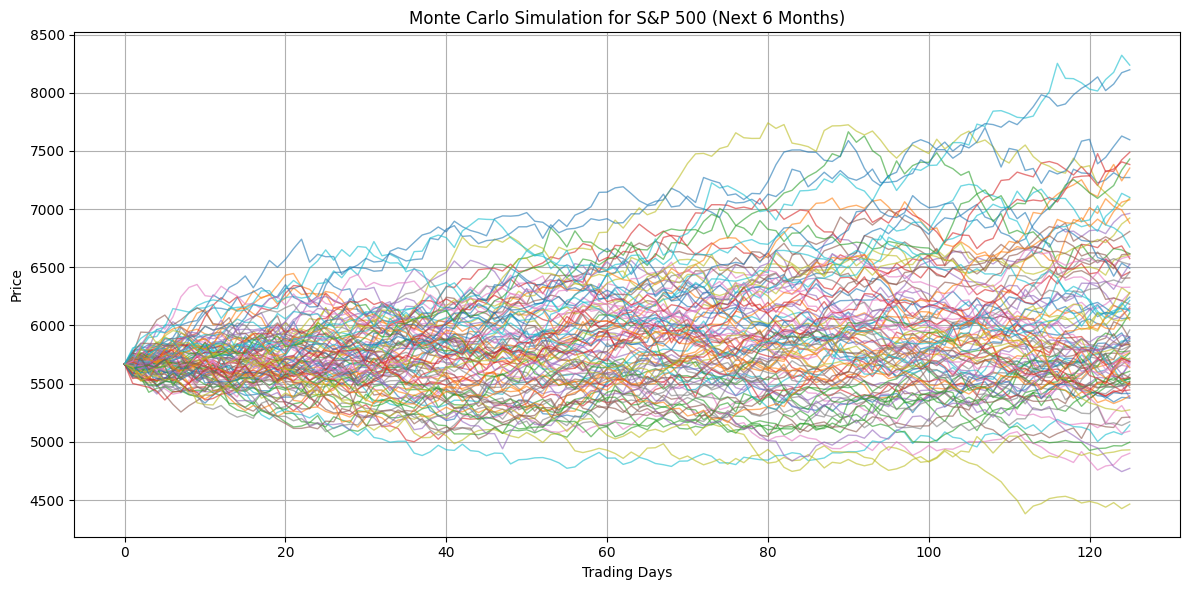

In [15]:
import os
import time

if not os.path.exists("historical_data"):
    os.makedirs("historical_data")

for symbol in top_50['symbol']:
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?serietype=line&timeseries=1000&apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    if "historical" in data:
        df = pd.DataFrame(data["historical"])
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        df.to_csv(f"historical_data/{symbol}.csv", index=False)
        print(f"Saved historical data for {symbol}")
    else:
        print(f"No data for {symbol}")
    time.sleep(1)  # respect rate limits


In [17]:
import requests
import pandas as pd

API_KEY = os.getenv('API_KEY')
top_50_url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={API_KEY}"

response = requests.get(top_50_url)
companies = response.json()
top_50 = pd.DataFrame(companies).head(50)  # Select top 50
top_50.to_csv("top_50_sp500.csv", index=False)
print("Saved top 50 S&P 500 companies.")


Saved top 50 S&P 500 companies.


In [18]:
import os
import time

if not os.path.exists("historical_data"):
    os.makedirs("historical_data")

for symbol in top_50['symbol']:
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?serietype=line&timeseries=1000&apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    if "historical" in data:
        df = pd.DataFrame(data["historical"])
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        df.to_csv(f"historical_data/{symbol}.csv", index=False)
        print(f"Saved historical data for {symbol}")
    else:
        print(f"No data for {symbol}")
    time.sleep(1)  # respect rate limits


Saved historical data for APO
Saved historical data for LII
Saved historical data for WDAY
Saved historical data for TPL
Saved historical data for DELL
Saved historical data for ERIE
Saved historical data for PLTR
Saved historical data for SW
Saved historical data for CRWD
Saved historical data for GDDY
Saved historical data for KKR
Saved historical data for VST
Saved historical data for GEV
Saved historical data for SOLV
Saved historical data for DECK
Saved historical data for SMCI
Saved historical data for BLDR
Saved historical data for JBL
Saved historical data for UBER
Saved historical data for HUBB
Saved historical data for LULU
Saved historical data for VLTO
Saved historical data for ABNB
Saved historical data for BX
Saved historical data for KVUE
Saved historical data for PANW
Saved historical data for AXON
Saved historical data for FICO
Saved historical data for BG
Saved historical data for PODD
Saved historical data for GEHC
Saved historical data for STLD
Saved historical data

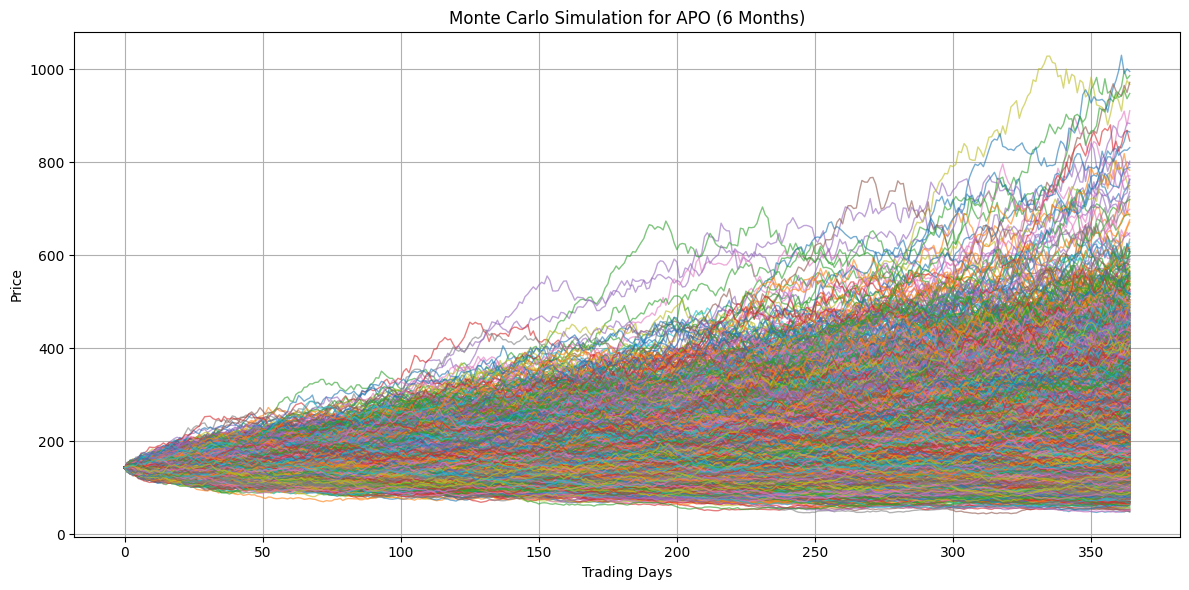

In [21]:
import numpy as np
import matplotlib.pyplot as plt

n_simulations = 5000
n_days = 365  # 1 year

def run_simulation(symbol):
    try:
        df = pd.read_csv(f"historical_data/{symbol}.csv", parse_dates=["date"])
        prices = df['close']
        returns = prices.pct_change().dropna()
        mu = returns.mean()
        sigma = returns.std()
        last_price = prices.iloc[-1]

        simulations = np.zeros((n_days, n_simulations))
        for i in range(n_simulations):
            prices_sim = [last_price]
            for _ in range(1, n_days):
                shock = np.random.normal(mu, sigma)
                prices_sim.append(prices_sim[-1] * (1 + shock))
            simulations[:, i] = prices_sim

        return simulations
    except Exception as e:
        print(f"Error for {symbol}: {e}")
        return None

# Run simulations and optionally plot one example
example_symbol = top_50['symbol'].iloc[0]
simulations = run_simulation(example_symbol)

plt.figure(figsize=(12, 6))
plt.plot(simulations, linewidth=1, alpha=0.6)
plt.title(f"Monte Carlo Simulation for {example_symbol} (6 Months)")
plt.xlabel("Trading Days")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
results = []

for symbol in top_50['symbol']:
    sims = run_simulation(symbol)
    if sims is not None:
        ending_prices = sims[-1, :]
        expected_return = (np.mean(ending_prices) - sims[0, 0]) / sims[0, 0]
        results.append({
            "symbol": symbol,
            "expected_return_6mo": expected_return,
            "std_dev": np.std(ending_prices)
        })

results_df = pd.DataFrame(results)
results_df.sort_values(by="expected_return_6mo", ascending=False, inplace=True)
results_df.to_csv("top_50_simulation_results.csv", index=False)
print("Saved simulation summary results.")


Saved simulation summary results.
